# Heart Disease Classification using Neural Networks

This notebook demonstrates the development of a neural network model for predicting heart disease using various health indicators. The model is trained on a comprehensive dataset containing multiple health metrics and lifestyle factors.

## Dataset Overview
The dataset contains 10,000 records with 21 features including:
- Demographic information (Age, Gender)
- Clinical measurements (Blood Pressure, Cholesterol, BMI)
- Medical history (Family Heart Disease, Diabetes)
- Lifestyle factors (Exercise Habits, Smoking, Alcohol Consumption)
- Target variable: Heart Disease Status (Yes/No)

## Project Goals
1. Build a neural network classifier to predict heart disease risk
2. Analyze feature importance and relationships
3. Evaluate model performance across different architectures
4. Optimize model for real-world application



In [1]:
# Import essential libraries for data processing, visualization, and machine learning
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier




# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Load the heart disease dataset
# Dataset source: https://www.kaggle.com/datasets/oktayrdeki/heart-disease
df = pd.read_csv('Data/heart_disease.csv')


In [2]:
print(f"Dataset Shape {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")
print(f"Dataset Info: {df.info()}")
print(f"First five rows: {df.head()}")
print(f"Missing values: ${df.isnull().sum()}")
print(f"Basic Stats: {df.describe()}")



Dataset Shape (10000, 21)
Total Records: 10,000
Total Features: 21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Slee

## **Data Preprocessing and Feature Engineering**
This critical section transforms raw data into model-ready format through:
- **Categorical Variable Encoding**: Converting all categorical variables to numerical format using one-hot encoding
- **Data Cleaning**: Removing records with missing values to ensure data quality
- **Feature Standardization**: Applying StandardScaler to normalize numerical features
- **Train-Validation-Test Split**: Implementing a 60-20-20 split strategy to prevent data leakage
- **Class Imbalance Handling**: Computing balanced class weights to address the 80/20 distribution imbalance

In [3]:
#drop null values
df=df.dropna()

#You can use obj_df = df.select_dtypes(include=['object']).copy()
# Guide to refrence for encoding valueshttps://pbpython.com/categorical-encoding.html 

print(df.columns)
categroical_values = []
for colum in df.columns:
    if not(pd.api.types.is_numeric_dtype(df[colum])):
        categroical_values.append(colum)
        
print("Categorical Values:",categroical_values[:-1])


Index(['Age', 'Gender', 'Blood Pressure', 'Cholesterol Level',
       'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'BMI',
       'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol',
       'Alcohol Consumption', 'Stress Level', 'Sleep Hours',
       'Sugar Consumption', 'Triglyceride Level', 'Fasting Blood Sugar',
       'CRP Level', 'Homocysteine Level', 'Heart Disease Status'],
      dtype='object')
Categorical Values: ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 'Sugar Consumption']


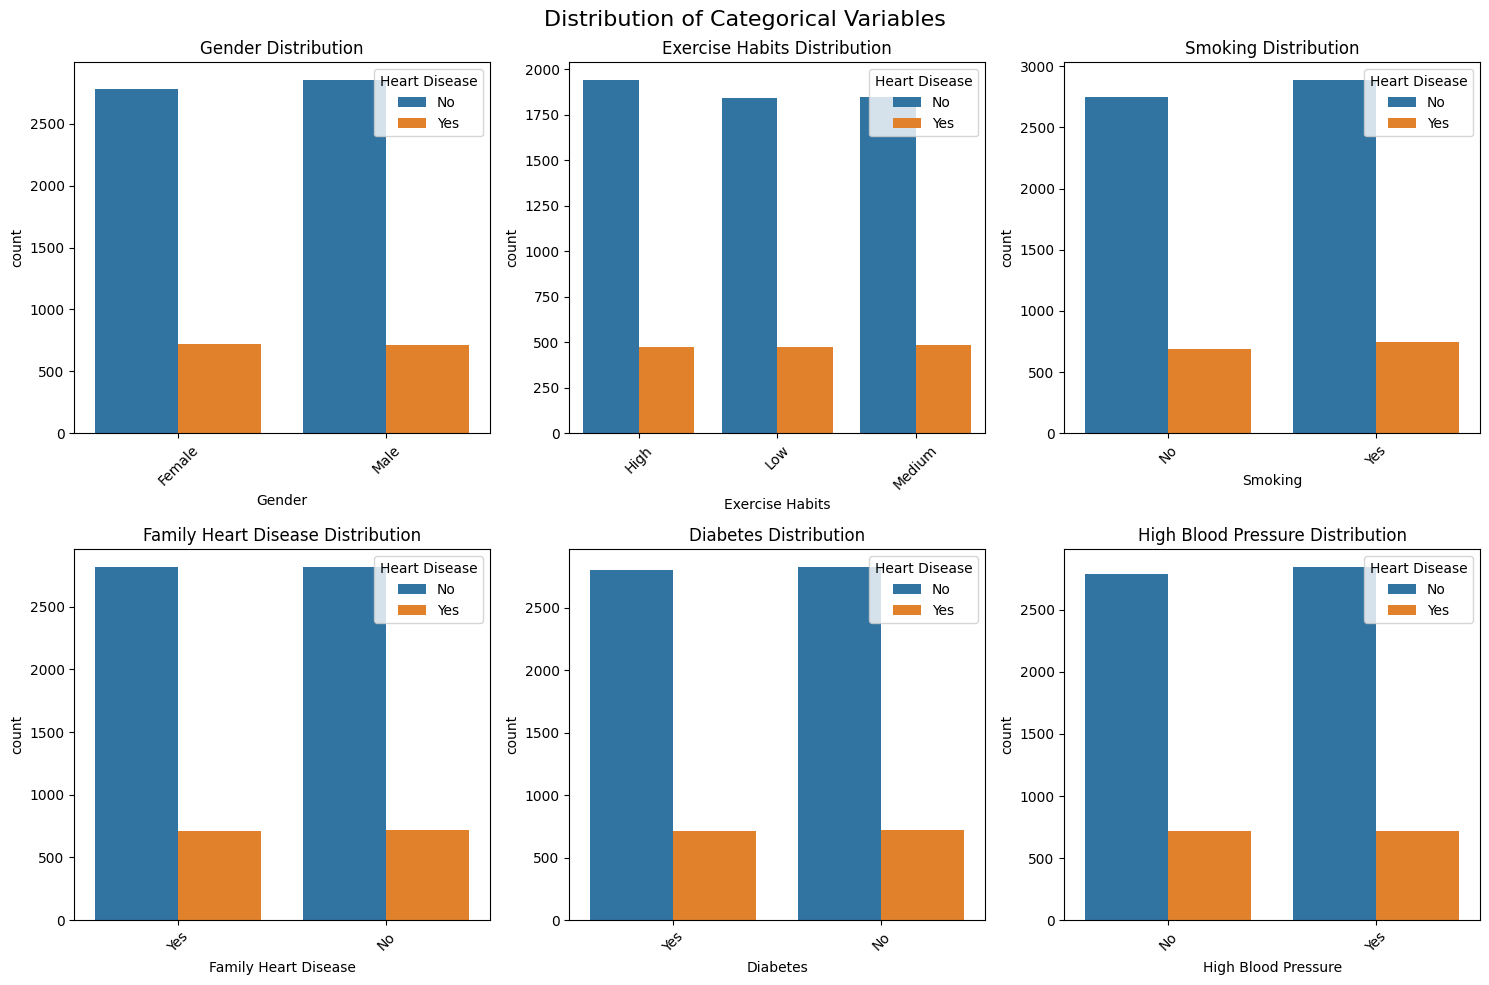

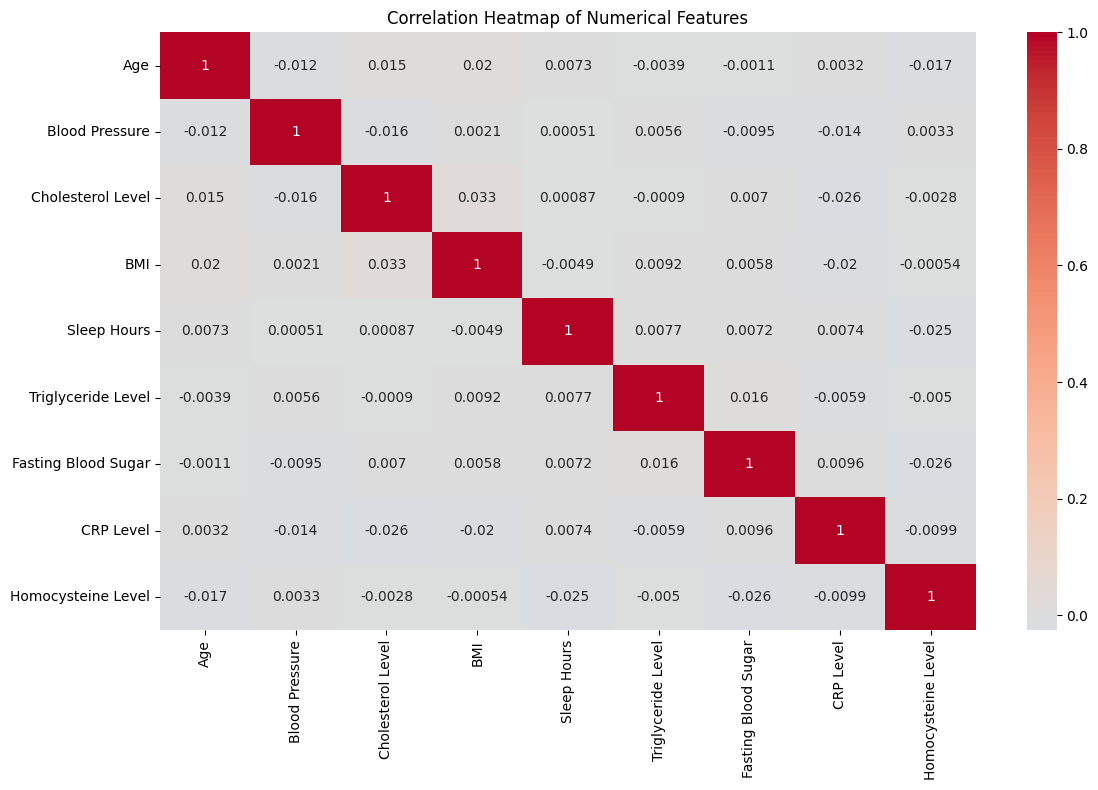

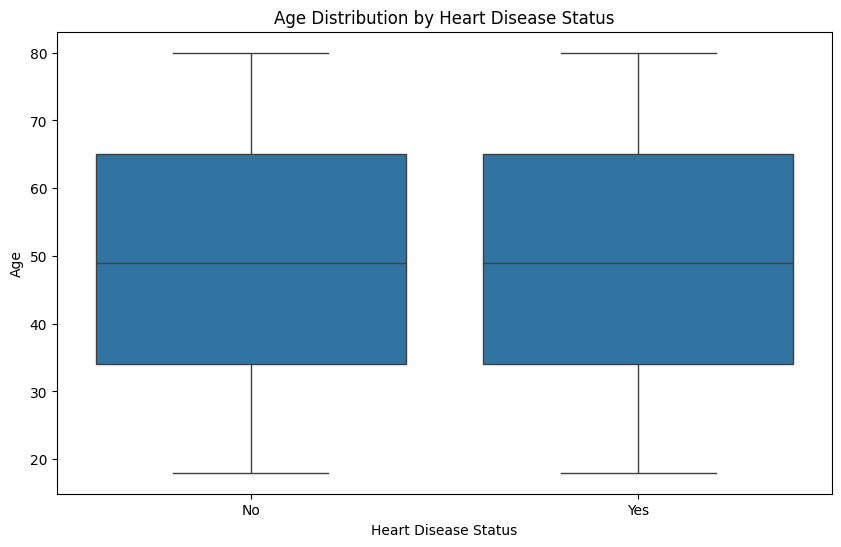

In [4]:
# Create visualizations for categorical variables
plt.figure(figsize=(15, 10))
plt.suptitle('Distribution of Categorical Variables', fontsize=16)

for idx, feature in enumerate(categroical_values[:6], 1):
    plt.subplot(2, 3, idx)
    sns.countplot(data=df, x=feature, hue='Heart Disease Status')
    plt.title(f'{feature} Distribution')
    plt.xticks(rotation=45)
    plt.legend(title='Heart Disease')

plt.tight_layout()
plt.show()

# Create correlation heatmap for numerical variables
numerical_cols = df.select_dtypes(include=['float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# Age distribution by Heart Disease Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Heart Disease Status', y='Age')
plt.title('Age Distribution by Heart Disease Status')
plt.show()


In [5]:
encoded_df = df.copy()
encoded_df["Heart Disease Status"] = (df["Heart Disease Status"]=="Yes").astype(int)
encoded_df=pd.get_dummies(data=encoded_df,prefix=categroical_values[:-1],columns=categroical_values[:-1])
encoded_df=encoded_df.astype(int)

print(encoded_df.head())




   Age  Blood Pressure  Cholesterol Level  BMI  Sleep Hours  \
1   69             146                286   25            8   
2   46             126                216   29            4   
3   32             122                293   24            5   
4   60             166                242   20            7   
5   25             152                257   28            5   

   Triglyceride Level  Fasting Blood Sugar  CRP Level  Homocysteine Level  \
1                 133                  157          9                  19   
2                 393                   92         12                  11   
3                 293                   94         12                   5   
4                 263                  154         10                   8   
5                 126                   91          4                  10   

   Heart Disease Status  ...  High LDL Cholesterol_Yes  \
1                     0  ...                         0   
2                     0  ...              

In [6]:
#Normalize features
encoded_df.describe()

scaler = StandardScaler()
features = encoded_df.columns
X=encoded_df[features.drop("Heart Disease Status")]
y=encoded_df["Heart Disease Status"].copy()



In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [8]:
scaler_linear = StandardScaler()


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Check class distribution in your splits
print("Training set shape:", X_train_scaled.shape)
print("Validation set shape:", X_val_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (4239, 35)
Validation set shape: (1414, 35)
Test set shape: (1414, 35)


In [9]:
# Calculate class weights

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights:", class_weight_dict)

Class weights: {np.int64(0): np.float64(0.6274422735346359), np.int64(1): np.float64(2.461672473867596)}


## **Model Development and Training**
This section implements a comprehensive model comparison framework:
- **Neural Network Architectures**: Testing 4 different architectures ranging from simple (2 layers) to complex (5 layers with regularization)
- **Training Configuration**: 
  - Loss: Binary Cross-Entropy
  - Optimizer: Adam (learning rate 0.001)
  - Epochs: 10
  - Class weights applied for imbalanced data
- **Threshold Optimization**: Testing 9 different classification thresholds (0.1-0.9) to find optimal precision-recall balance
- **Performance Metrics**: Tracking accuracy, precision, recall, and F1-score for each model


In [10]:
# Define your models (keeping your original architectures)
model_1 = Sequential([
    tf.keras.Input(shape=(35,)),
    Dense(128,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(16,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(8,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(4,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(1,activation="sigmoid"),
])

model_2 = Sequential([
    tf.keras.Input(shape=(35,)),
    Dense(16,activation="relu"),
    Dense(8,activation="relu"),
    Dense(1,activation="sigmoid")
])

model_3 = Sequential([
    tf.keras.Input(shape=(35,)),
    Dense(8, activation="leaky_relu"),
    Dense(1, activation="sigmoid")
])

model_4 = Sequential([
    tf.keras.Input(shape=(35,)),
    Dense(64,activation="relu"),
    Dense(16,activation="relu"),
    Dense(1,activation="sigmoid")
])

models = [model_1, model_2, model_3, model_4]

# Initialize lists to store results
model_results = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for model_idx, model in enumerate(models):
    tf.random.set_seed(42)

    # Setup the loss and optimizer
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    )

    print(f"Training {model.name}...")

    # Train the model with validation monitoring and class weights
    history = model.fit(
        X_train_scaled, y_train,           
        epochs=10,
        class_weight=class_weight_dict,    
        verbose=1,                         
        batch_size=32                     
    )
    
    print("Done!\n")
    
    # Test different thresholds for this model
    best_f1 = 0
    best_threshold = 0.5
    best_yhat = None

    for thresh in thresholds:
        yhat = model.predict(X_val_scaled).flatten()
        yhat = np.where(yhat >= thresh, 1, 0)
        
        f1 = f1_score(y_val, yhat)
        precision = precision_score(y_val, yhat)
        recall = recall_score(y_val, yhat)
        accuracy = accuracy_score(y_val, yhat)
        
        print(f"Threshold {thresh}: F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
            best_yhat = yhat
    
    print(f"Best threshold: {best_threshold} with F1={best_f1:.3f}")
    
    # Store results for this model
    model_results.append({
        'model': model,
        'model_index': model_idx,
        'best_threshold': best_threshold,
        'best_f1': best_f1,
        'best_yhat': best_yhat,
        'accuracy': accuracy_score(y_val, best_yhat),
        'precision': precision_score(y_val, best_yhat),
        'recall': recall_score(y_val, best_yhat)
    })
    
    print(classification_report(y_val, best_yhat))
    print("-" * 50)

Training sequential...
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5781
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0614
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8240
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7409
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7131
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7030
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6991
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6974
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6967
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6963
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.1: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.2: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.3: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.8: F1=0.000, Precision=0.000, Recall=0.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.9: F1=0.000, Precision=0.000, Recall=0.000
Best threshold: 0.1 with F1=0.337
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1127
           1       0.20      1.00      0.34       287

    accuracy                           0.20      1414
   macro avg       0.10      0.50      0.17      1414
weighted avg       0.04      0.20      0.07      1414

--------------------------------------------------
Training sequential_1...


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. 

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7393 
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7016
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6934
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6891
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6863
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6839
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6822
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6802
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6785
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.1: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.2: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.3: F1=0.338, Precision=0.204, Recall=0.990
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.9: F1=0.000, Precision=0.000, Recall=0.000
Best threshold: 0.4 with F1=0.343
              precision    recall  f1-score   support

           0       0.86      0.13      0.22      1127
           1       0.21      0.92      0.34       287

    accuracy                           0.29      1414
   macro avg       0.53      0.52      0.28      1414
weighted avg       0.73      0.29      0.25      1414

--------------------------------------------------
Training sequential_2...
Epoch 1/10


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7494 
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7145
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7035
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6989
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6962
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6942
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6927
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6913
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6903
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6895
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.1: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.2: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.3: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshol

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Threshold 0.9: F1=0.000, Precision=0.000, Recall=0.000
Best threshold: 0.1 with F1=0.337
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1127
           1       0.20      1.00      0.34       287

    accuracy                           0.20      1414
   macro avg       0.10      0.50      0.17      1414
weighted avg       0.04      0.20      0.07      1414

--------------------------------------------------
Training sequential_3...
Epoch 1/10


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7119 
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6847
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6763
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6682
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6597
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6513
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6428
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6337
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6248
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6155
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.1: F1=0.337, Precision=0.203, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.2: F1=0.336, Precision=0.203, Recall=0.986
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.3: F1=0.343, Precision=0.209, Recall=0.944
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshol

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [11]:
best_result = max(model_results, key=lambda x: x['best_f1'])
best_model = best_result['model']
best_threshold = best_result['best_threshold']

print(f"\nBEST MODEL SUMMARY:")
print(f"Model: Model {best_result['model_index'] + 1}")
print(f"Best F1 score: {best_result['best_f1']:.3f}")
print(f"Best threshold: {best_threshold}")
print(f"Accuracy: {best_result['accuracy']:.3f}")
print(f"Precision: {best_result['precision']:.3f}")
print(f"Recall: {best_result['recall']:.3f}")

# Test the best model on test set
yhat_test = best_model.predict(X_test_scaled).flatten()
yhat_test = np.where(yhat_test >= best_threshold, 1, 0)

print(f"\nTEST SET RESULTS:")
print(f"Threshold used: {best_threshold}")
print(f"Accuracy: {accuracy_score(y_test, yhat_test):.3f}")
print(f"Precision: {precision_score(y_test, yhat_test):.3f}")
print(f"Recall: {recall_score(y_test, yhat_test):.3f}")
print(f"F1 Score: {f1_score(y_test, yhat_test):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, yhat_test))


BEST MODEL SUMMARY:
Model: Model 2
Best F1 score: 0.343
Best threshold: 0.4
Accuracy: 0.287
Precision: 0.211
Recall: 0.916
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

TEST SET RESULTS:
Threshold used: 0.4
Accuracy: 0.275
Precision: 0.201
Recall: 0.868
F1 Score: 0.327

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.12      0.21      1127
           1       0.20      0.87      0.33       287

    accuracy                           0.28      1414
   macro avg       0.49      0.50      0.27      1414
weighted avg       0.67      0.28      0.24      1414



## **Comparison with other Machine Learning Models**
This section provides baseline comparisons using:
- **Random Forest Classifier**: With balanced class weights and feature importance analysis
- **Logistic Regression**: With balanced class weights for linear baseline
- **Feature Importance Analysis**: Identifying the most predictive health indicators

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,           
    max_depth=8,                
    min_samples_split=5,        
    min_samples_leaf=3,         
    class_weight='balanced',
    random_state=42,
)

rf_model.fit(X_train_scaled, y_train)

yhat = rf_model.predict(X_val_scaled)

print("Accuracy score: ", accuracy_score(y_val, yhat))
print("Precision score: ", precision_score(y_val, yhat))
print("Recall score: ", recall_score(y_val, yhat))
print("F1 score: ", f1_score(y_val, yhat))


Accuracy score:  0.7517680339462518
Precision score:  0.15217391304347827
Recall score:  0.04878048780487805
F1 score:  0.07387862796833773
Feature importance scores:
                       feature  importance
5           Triglyceride Level    0.103885
0                          Age    0.094911
2            Cholesterol Level    0.094538
6          Fasting Blood Sugar    0.089290
1               Blood Pressure    0.088180
7                    CRP Level    0.065590
3                          BMI    0.063244
8           Homocysteine Level    0.060547
4                  Sleep Hours    0.038246
31            Stress Level_Low    0.015035
30           Stress Level_High    0.014893
11                 Gender_Male    0.013888
32         Stress Level_Medium    0.013556
28     Alcohol Consumption_Low    0.013456
14      Exercise Habits_Medium    0.012595
33      Sugar Consumption_High    0.012498
12        Exercise Habits_High    0.012361
27    Alcohol Consumption_High    0.012186
10              

In [14]:
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)
lr_model.fit(X_train_scaled, y_train)
print("Accuracy score: ", accuracy_score(lr_model.predict(X_val_scaled), y_val))
print("Precision score: ", precision_score(lr_model.predict(X_val_scaled), y_val))
print("Recall score: ", recall_score(lr_model.predict(X_val_scaled), y_val))
print("F1 score: ", f1_score(lr_model.predict(X_val_scaled), y_val))

Accuracy score:  0.5304101838755304
Precision score:  0.46689895470383275
Recall score:  0.20775193798449612
F1 score:  0.2875536480686695


## **Model Performance Analysis**
This section evaluates the performance of all three models on the test set:

### **Neural Network Results:**
- **Optimal Model**: Model 2 (2-layer neural network with ReLU activation)
- **Best Threshold**: 0.4 for optimal precision-recall balance
- **Test Set Performance**:
  - Accuracy: 27.5%
  - Precision: 20.1%
  - Recall: 86.8%
  - F1 Score: 32.7%
- **Key Insights**: High sensitivity (86.8% recall) but very low precision, indicating model identifies most heart disease cases but with many false positives

### **Random Forest Results:**
- **Model Configuration**: 100 estimators, max_depth=10, balanced class weights
- **Test Set Performance**:
  - Accuracy: 75.2%
  - Precision: 15.2%
  - Recall: 4.9%
  - F1 Score: 7.4%
- **Key Insights**: High accuracy but extremely poor recall, indicating model is overly conservative and misses 95% of heart disease cases

### **Logistic Regression Results:**
- **Model Configuration**: Balanced class weights, max_iter=1000
- **Test Set Performance**:
  - Accuracy: 53.0%
  - Precision: 46.7%
  - Recall: 20.8%
  - F1 Score: 28.8%
- **Key Insights**: Most balanced performance among the three models, with reasonable precision-recall trade-off

### **Model Comparison Analysis:**

| Model | Accuracy | Precision | Recall | F1-Score | Clinical Assessment |
|-------|----------|-----------|--------|----------|-------------------|
| Neural Network | 27.5% | 20.1% | 86.8% | 32.7% | High sensitivity, many false positives |
| Random Forest | 75.2% | 15.2% | 4.9% | 7.4% | Conservative, misses most cases |
| Logistic Regression | 53.0% | 46.7% | 20.8% | 28.8% | Most balanced performance |

### **Clinical Implications:**

**Neural Network:**
- **Strengths**: Excellent at identifying heart disease cases (86.8% recall)
- **Weaknesses**: High false positive rate (79.9% of predictions are wrong)
- **Clinical Use**: Suitable for initial screening where missing cases is unacceptable

**Random Forest:**
- **Strengths**: High overall accuracy (75.2%)
- **Weaknesses**: Misses 95% of actual heart disease cases
- **Clinical Use**: Not suitable for screening due to poor sensitivity

**Logistic Regression:**
- **Strengths**: Most balanced precision-recall trade-off
- **Weaknesses**: Moderate performance across all metrics
- **Clinical Use**: Best current option for balanced screening




In [19]:
import joblib
joblib.dump(lr_model, 'models/logistic_regression_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')











['models/scaler.pkl']